In [2]:
import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np

def load_png(image_path):
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def visualize_png_image(image):
    """
    image: an output of load_png function
    """
    plt.imshow(image)
    
def save_array_as_image(array, name):
     imageio.imwrite(name, array)

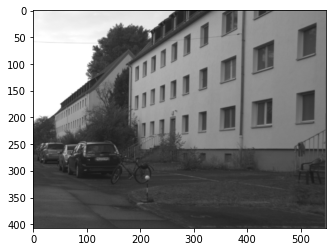

In [5]:
file_name = 'road'
image = load_png('{}.png'.format(file_name))
# image = np.asarray(image, dtype=np.float32)
visualize_png_image(image)

# Gaussian Filtering

In [6]:
import numpy as np
import math

class GaussFilter:
    def __init__(self, 
                 std_dev, 
                 kernel_dimension=None):
        self.std_dev = std_dev
        if not kernel_dimension:
            self.kernel_dimension = self.compute_kernel_dimensions(std_dev)
        else:
            self.kernel_dimension = kernel_dimension 
        self.kernel = self.generate_gaussian_kernel(std_dev)
    
    @staticmethod
    def compute_kernel_dimensions(std_dev):
        return int(1 + 2*(3*std_dev))

    def get_gaussian_coordiantes(self, x, y):
        center = int(self.kernel_dimension/2) + 1
        origin = center - 1
        gauss_x = x - origin
        gauss_y = y - origin
        
        return gauss_x, gauss_y
    
    def compute_gaussian_pixel_value(self, gauss_x, gauss_y):
        std_squared = self.std_dev**2
        pi = math.pi
        pixel_value = math.exp(-(gauss_x**2 + gauss_y**2)/(2*std_squared))/(2*pi*std_squared)
        return pixel_value

    def generate_gaussian_kernel(self, std_dev):
        """
        std_dev: value of standard deviation in terms of pixels
        """
        k = self.kernel_dimension
        kernel = np.zeros((k, k))
        
        for x, y in np.ndindex((k, k)):
            gauss_x, gauss_y = self.get_gaussian_coordiantes(x, y)
            kernel[x, y] = self.compute_gaussian_pixel_value(gauss_x, gauss_y)
            
        return kernel/sum(sum(kernel))

Text(0.5, 1.0, 'Gaussian Kernel\nStandard Deviation = 10\nKernel Dimension = 61x61')

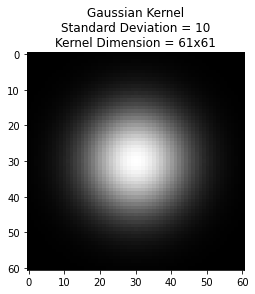

In [7]:
kernel = GaussFilter(10)
k = kernel.kernel

plt.imshow(k/k.max(), cmap='gray', vmin=0, vmax=1)
plt.title('Gaussian Kernel\nStandard Deviation = {0}\nKernel Dimension = {1}x{1}'.format(kernel.std_dev, kernel.kernel_dimension))

In [8]:
def _filter(image, kernel, 
             stride=(1, 1),
             padding=None,):
    
    num_channels = image.shape[2]
    kernel_extended = np.asarray([kernel for i in range(num_channels)]).reshape(kernel.shape[0], 
                                                                                        kernel.shape[1], 
                                                                                        num_channels)
    
    image_height, image_width, image_channels = image.shape
    kernel_height, kernel_width, kernel_channels = kernel_extended.shape
    
    stride_height, stride_width = stride
       
    if padding is None:
        width_padding = int(((image_width - 1)*stride_width + kernel_width - image_width)/2)
        height_padding = int(((image_height - 1)*stride_height + kernel_height - image_height)/2)
    else:
        height_padding, width_padding = padding
        
    
    input_image = np.zeros((height_padding + image_height + height_padding, width_padding + image_width + width_padding, image_channels))
    input_image[height_padding:image_height + height_padding, width_padding:image_width + width_padding, :] = image.copy()  
    
    input_height, input_width, input_channels = input_image.shape
    
    output_height = int((input_height - kernel_height)/stride_height) + 1
    output_width = int((input_width - kernel_width)/stride_width) + 1
    
    output_image = np.zeros((output_height, output_width, input_channels))
    
    for x in range(0, output_width):
        for y in range(0, output_height):
            output_image[y, x, :] = np.einsum('ij,ijk->k', 
                                              kernel, 
                                              input_image[y*stride_height:y*stride_height + kernel_height, 
                                                          x*stride_width:x*stride_width + kernel_width, :])
    
    return output_image

def convolve(image, kernel, 
             stride=(1, 1),
             padding=None,):

    kernel_flipped = np.rot90(np.flipud(kernel.T))
    
    return _filter(image, kernel_flipped, stride, padding)


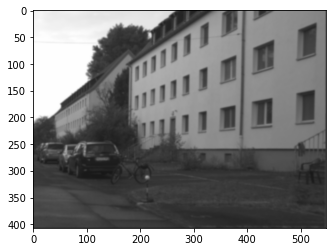

In [10]:
output = convolve(image, GaussFilter(1).kernel)
plt.imshow(np.asarray(output, dtype='uint8'), cmap='gray')

# First Order Derivative

In [11]:
sobel = np.asarray([[-1, 0, 1],[-2, 0, 2], [-1, 0, 1]])
sobel_h = sobel
sobel_v = sobel.T

Text(0.5, 1.0, 'Image gradient along the horizontal')

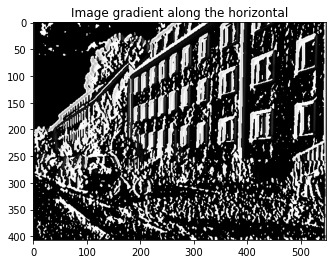

In [12]:
g_h = _filter(output, sobel_h)
save_array_as_image(np.asarray(255*g_h/g_h.max(), dtype='uint8'), 'results/{}_horizontal_gradient.jpg'.format(file_name))

plt.imshow(np.asarray(255*g_h/g_h.max(), dtype='uint8'), cmap='gray')
plt.title('Image gradient along the horizontal')

Text(0.5, 1.0, 'Image gradient along the vertical')

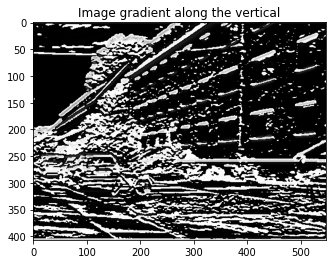

In [13]:
g_v = _filter(output, sobel_v)
save_array_as_image(np.asarray(255*g_v/g_v.max(), dtype='uint8'), 'results/{}_vertical_gradient.jpg'.format(file_name))

plt.imshow(np.asarray(255*g_v/g_v.max(), dtype='uint8'), cmap='gray')
plt.title('Image gradient along the vertical')

# Second Order Derivative

In [14]:
g_hh = _filter(g_h, sobel_h)
save_array_as_image(np.asarray(255*g_hh/g_hh.max(), dtype='uint8'), 'results/{}_Ixx.jpg'.format(file_name))

g_vv = _filter(g_v, sobel_v)
save_array_as_image(np.asarray(255*g_vv/g_vv.max(), dtype='uint8'), 'results/{}_Iyy.jpg'.format(file_name))

g_hv = _filter(g_h, sobel_v)
save_array_as_image(np.asarray(255*g_hv/g_hv.max(), dtype='uint8'), 'results/{}_Ixy.jpg'.format(file_name))

g_vh = _filter(g_v, sobel_h)
save_array_as_image(np.asarray(255*g_vh/g_vh.max(), dtype='uint8'), 'results/{}_Iyx.jpg'.format(file_name))

Text(0.5, 1.0, 'Ixx')

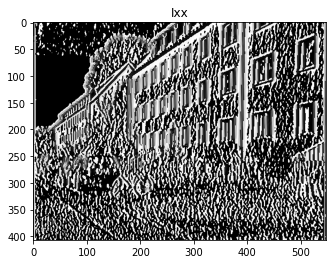

In [15]:
plt.imshow(np.asarray(255*g_hh/g_hh.max(), dtype='uint8'), cmap='gray')
plt.title('Ixx')

Text(0.5, 1.0, 'Ixy')

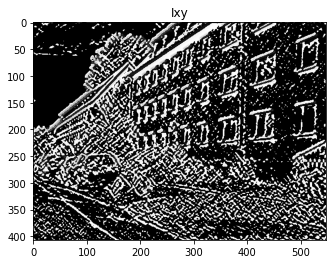

In [16]:
plt.imshow(np.asarray(255*g_hv/g_hv.max(), dtype='uint8'), cmap='gray')
plt.title('Ixy')

Text(0.5, 1.0, 'Iyx')

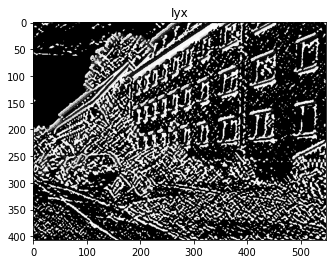

In [17]:
plt.imshow(np.asarray(255*g_vh/g_vh.max(), dtype='uint8'), cmap='gray')
plt.title('Iyx')

Text(0.5, 1.0, 'Iyy')

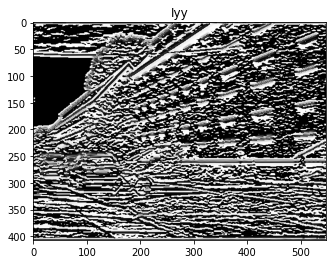

In [18]:
plt.imshow(np.asarray(255*g_vv/g_vv.max(), dtype='uint8'), cmap='gray')
plt.title('Iyy')

# Corner Detection - Hessian Determinant

In [19]:
hessian_without_thresh = g_hh*g_vv - g_hv*g_vh
norm_hess_without_thresh = 255*hessian_without_thresh/hessian_without_thresh.max()

In [20]:
thresh = 2
hessian = norm_hess_without_thresh*np.asarray(norm_hess_without_thresh > thresh, dtype='float')

In [21]:
hessian.max()

255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


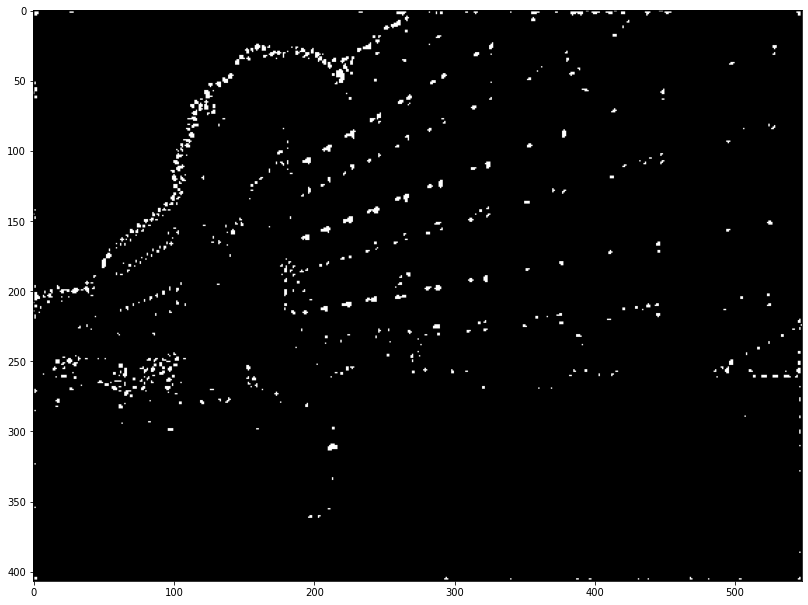

In [22]:
figure, ax = plt.subplots(1, 1)
ax.imshow(hessian)
figure.set_size_inches(18.5, 10.5)

# Non Maximum Suppression 

To detect corners a pixel is compared with all of its 8 neighbouring pixels and if the pixel value is larger than each and every one of the pixel values at its neighbouring locations then we choose the pixel value as a CORNER POINT.

In [23]:
import numpy as np

def get_comparison_filters():
    top = np.asarray([[0,-1,0],[0,1,0],[0,0,0]])
    top_left = np.asarray([[-1,0,0],[0,1,0],[0,0,0]])
    top_right = np.asarray([[0,0,-1],[0,1,0],[0,0,0]])
    left = np.asarray([[0,0,0],[-1,1,0],[0,0,0]])
    right = np.asarray([[0,0,0],[0,1,-1],[0,0,0]])
    bottom = np.asarray([[0,0,0],[0,1,0],[0,-1,0]])
    bottom_left = np.asarray([[0,0,0],[0,1,0],[-1,0,0]])
    bottom_right = np.asarray([[0,0,0],[0,1,0],[0,0,-1]])
    
    return top_left, top, top_right, left, right, bottom_left, bottom, bottom_right



def non_max_suppression(gradient):
    height, width, channels = gradient.shape
    
    nms_gradient = np.zeros((height, width, channels))

    for x in range(1, width-1):
        for y in range(1, height-1):
            filters = get_comparison_filters()
            values = [np.einsum('ij,ijk->k', _filter_, gradient[y-1:y+1+1, x-1:x+1+1, :]) for _filter_ in filters]            
            
            value = values[0]
            for i in range(1, len(values)):
                value = (values[i] > 0) & (value > 0)
            
            comparison = np.asarray(value, dtype = 'int')
            
            # nms_gradient[y,x,:] = gradient[y, x, :]*comparison
            
            # if np.array_equal(comparison, np.asarray([1, 1, 1])):
            #     print('\nlocation', y, x)
            #     print('nms', nms_gradient[y,x,:])
            #     print('hess', gradient[y,x,:])
            
            nms_gradient[y,x,:] = comparison
    
    return nms_gradient

In [24]:
nms = non_max_suppression(hessian)

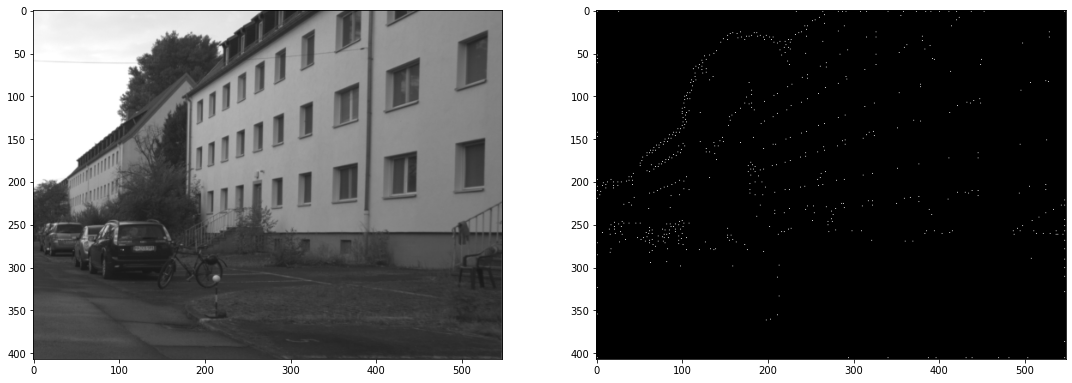

In [25]:
figure, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(nms)
figure.set_size_inches(18.5, 10.5)

In [65]:
save_array_as_image(np.asarray(255*nms/nms.max(), dtype='uint8'), 'results/{}_nms_2.jpg'.format(file_name))